# Overview

In this notebook we aim to accomplish the following: 

1. Take a corpus of NYT articles
2. Cluster the articles for potential tagging
3. Explain the methods used and expand on how they could be expaned on in the future
4. Visualize the results

In [1]:
#data methods
import pandas as pd
import numpy as np
#NLP methods
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer #Three stemmers for data simplification
from nltk.tokenize import sent_tokenize, word_tokenize # Tokenizers for data cleaning
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = set(stopwords.words('english'))
import re
#plotting functions
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline
sns.set()
#code reproducability
np.random.seed(31415) 

In [2]:
! ls

Axios_coding.ipynb   nytimes articles.csv


In [3]:
df = pd.read_csv('nytimes articles.csv')

## Helper functions

Here we build out some helper functions that help with data cleaning and preparation for clustering

In [4]:
def remove_stopwords(strTokens, stopWords=stop_words):
    '''Provided a list of stop words, this function removes stop words and any words that are not strictly letters'''
    if strTokens is not None:
        return [j.strip().lower() for j in strTokens if j.strip().lower() not in stopWords and re.match('^[A-Za-z]*$',j)]
    return strTokens

def tokenize(strToken):
    '''This function uses the sent_tokenize and word_tokenize to tokenize the words in a article. 
    
    ToDo: Make sent_tokenize and word_tokenize parameters to this function
    '''
    if strToken == strToken:
        return [word for sent in sent_tokenize(strToken) for word in word_tokenize(sent)]
    return []

def stemmer(tokens, stemmerFxn):
    '''Provided a list[str] and a stemmer function it will reduce workds like lose-> los and losing -> los. This is 
    a key function to make it so that we can learn a flexible model'''
    return [stemmerFxn.stem(j) for j in tokens]

def getAuthors(authString, regFilter=r"\sand\s|,\s"):
    '''author column contains multiple authors'''
    if authString == authString:
        return [j for j in re.split(regFilter, authString) if len(j) > 0]
    return []

def tokenizeThenStemm(strToken, stopWords=stop_words, stemmerFxn=SnowballStemmer('english')):
    '''wrapper function that tokenizes, removes stopwords, then stemms. Default is SnowballStemmer, a 
    medium aggressive stemmer. '''
    if strToken == strToken:
        return stemmer(remove_stopwords(tokenize(strToken), stopWords=stop_words), stemmerFxn)
    return []

## Cleaning an preprocessing the data

The dataset we have is actually relatively clean, with the exception of a small number of rows that have titles or article text missing. These are removed from training later in the notebook. 

The majority of the work surrounding cleaning is via tokenization, stop word removal, regular expressions to handle simple tasks (such as geting a list of authors per article), and word stemming. These are all import steps for analysis and training in an NLP framework. 

### First we look at the stemmedTitle and stemmedContent to get word frequency information

We join in the title so that short articles have more context and we can get a better view of the overall word count

In [5]:
stemmedTitleContent = (df.title + " " + df.content).apply(lambda x: tokenizeThenStemm(x, 
                                                                                      stopWords=stop_words, 
                                                                                      stemmerFxn=SnowballStemmer('english')))

In [6]:
word_counts = stemmedTitleContent.apply(pd.Series).stack().reset_index(drop=True)
value_counts = word_counts.value_counts()

## Plotting the word count 

As we would expect with [zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), there are not an equal ranking of words in the documents. High count words, as well as low count words, do not add to the context of clustering and will therefore be excluded from training. 

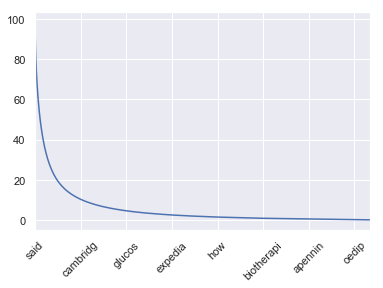

In [7]:
wordProb = 100*(value_counts/value_counts.sum())
(100-wordProb.cumsum()).plot(rot=45)

### Removing the following words as they occur at the highest rate. 

If this were more rigorous, this would be more statistically rigorous. 'said' and 'trump' occur the higest. We also add 'new','york', and 'times' because this is the title of the the NYT. In training we will also only use the highest 80% of words by their cumulative probability.

In [8]:
stop_words.add('said')
stop_words.add('trump')
stop_words.add('new')
stop_words.add('york')
stop_words.add('times')

In [9]:
trainingData = df.copy()
trainingData['authors'] = trainingData.author.apply(lambda x: getAuthors(x))
trainingData['titleToken'] = trainingData.title.apply(lambda x: remove_stopwords(tokenize(x)))
trainingData['contentToken'] = trainingData.content.apply(lambda x: remove_stopwords(tokenize(x)))

## For the training we will be using TF-IDF with ngrams

This gives a sense of the word frequency while preserving the document information into the training matrix. As we have a small corpus, we will be using 1-3 ngrams and using the top 80% of probable words. The ngrams encode information about the context of a word into the feature vector, partially encoding symantic meaning to each word, making the input feature space more descriptive to human language.

In [10]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), tokenizer=tokenizeThenStemm,max_features=wordProb.cumsum()[wordProb.cumsum() < 80.].shape[0])
contentFeatures = tfidf_vectorizer.fit_transform(trainingData[trainingData.content.notna()].content)

# Training

Model selection for this problem are unsupervised learning clustering algorithms. These are needed because our training data is unlabeled. In this workbook we explore two models: 

1. [Kmeans clustering](https://en.wikipedia.org/wiki/K-means_clustering)
2. [Hierarchical Clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)

Kmeans is a simple form of clustering based on distance measures while hierarchical clustering clusters data with a hierarchy of information, potentially learning a more robust model. 

### Kmeans clustering

A simple clustering algorithm that can be learned is the K-Means clustering. This is a distance-measure clustering algorithm. As we would expect articles that have similar themes to have similar features, this is a good place to start

In [11]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans #we will be using MiniBatchKMeans because of time constraints

### Determining the number of clusters to use

In this case we will be using the elbow method. This requires us to train a model for each of the cluters we are interested in, here 1-20

In [12]:
kmeansModels = []
distortions = []
for num_clusters in range(1,21):
    KM = MiniBatchKMeans(n_clusters=num_clusters)
    KM.fit(contentFeatures)
    kmeansModels.append(KM)

### Elbow method

Generally we would like to see an elbow in the plot in some way, or a discontinuity in the 'inertia' of the cluster models. It appears that a smal elbow happesn at 12 clusters, though more time should be spent making sure the feature space is representative of the training.

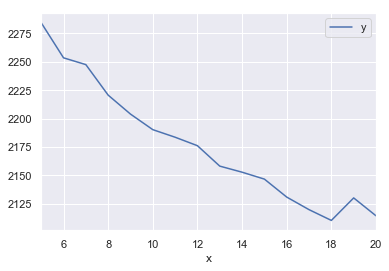

In [13]:
elbow_plot = [{'x':i[0],'y':i[1].inertia_} for i in zip(range(5,21),kmeansModels)]
pd.DataFrame(elbow_plot).plot(x='x',y='y')

### Determinging cluster counts and names

Here we manually select 13 clusters (13 - 1 in the list), and calculate their id followed by their cluster "name" determined by the highest 3 words in the cluster's article titles. We use the title because they are naturally more likely to be keyword-oriented and might describe the clusters better. We keep three because we may be interested in classifying the overlap of clusters with other documents. 


If given more time, cluster 0 has a very low number of articles, this indicates that there might be a more optimal number of clusters.

In [14]:
predictData = trainingData[trainingData.content.notna()].copy()
predictData['km'] = kmeansModels[12].labels_
predictData['km'].value_counts()

8     494
5     488
7     351
1     254
2     248
6     185
11    136
3     118
4      71
12     60
10     45
9      33
0       4
Name: km, dtype: int64

In [15]:
# this simply maps the cluster number to a tuple of names by most frequent titles. We use the title 
# because it could contain better summary information. 
# Future analysis could include keyword calculation from the document text as well
cluster_names = {}
for i in predictData['km'].value_counts().index:
    clusters_ = predictData[predictData.km == i].titleToken.apply(pd.Series).stack().reset_index(drop=True).value_counts().index
    cluster_names[i] = tuple(clusters_[j] for j in range(0,3))

In [16]:
cluster_names

{8: ('review', 'california', 'today'),
 5: ('china', 'briefing', 'syria'),
 7: ('briefing', 'evening', 'house'),
 1: ('police', 'men', 'death'),
 2: ('uber', 'billion', 'pay'),
 6: ('la', 'women', 'first'),
 11: ('ban', 'travel', 'immigration'),
 3: ('russia', 'russian', 'house'),
 4: ('health', 'republicans', 'care'),
 12: ('gorsuch', 'court', 'supreme'),
 10: ('korea', 'north', 'south'),
 9: ('museum', 'art', 'artist'),
 0: ('presidential', 'fillon', 'french')}

In [17]:
predictData['km_label'] = predictData.km.map(cluster_names) #giving labels to the names

### Plotting clusters

As we cannot visualize a the input vector space to view our clusters and we do not have a way to numerically judge our algorithm performace, we need to dimensionally reduce the clusters for plotting. Common methods for this a [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). Here we use t-SNE because it is probablalistic in nature. Once plotted, we can visually check the output to see if it uniquely clustered the data. 

As we see, there are natural visual clusters that are formed, but with quite a lot of overlap. This indicates that we may have too many clusters for our data set, we have too many features for training, or that our plotting method is not distinguishing them well enough. Given more time, these should all be explored. 

In [18]:
X_embedded = TSNE(n_components=2).fit_transform(contentFeatures.toarray())

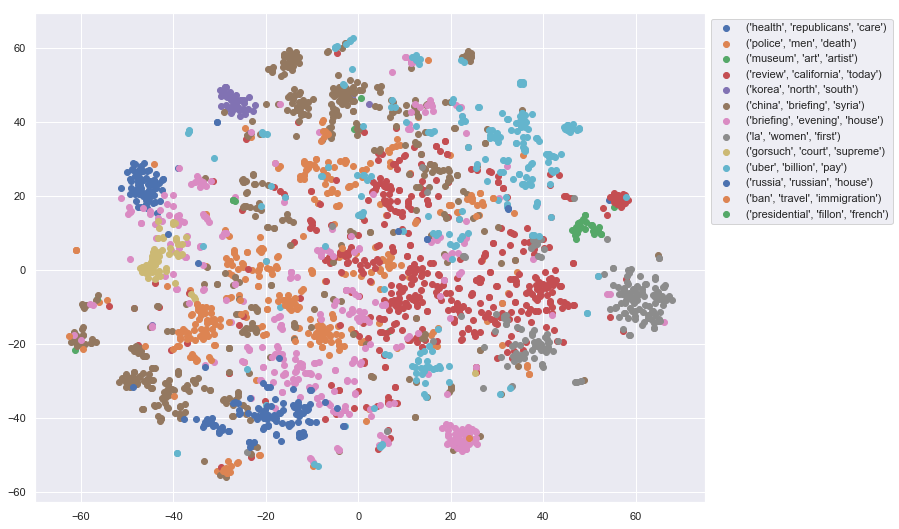

In [19]:
plt.figure(figsize=(12,9))
predictData['X'] = X_embedded[:,0]
predictData['Y'] = X_embedded[:,1]
for i in predictData.km_label.unique():
    plt_data = predictData[predictData.km_label == i]
    plt.scatter(plt_data.X, plt_data.Y, label=i)
    
plt.legend(bbox_to_anchor=(1.0, 1.0))

### Determining authorship by category

Here we show which authors contribute the most to each category. This could be used as a way to sanity check the clusters that are learned, or as a way to recommend articles to readers based on the author and category they are reading. Here we only show the highest hit author, but all are calculated. 

In [20]:
authorship = {}
for i in predictData.km_label.unique():
    t_data = predictData[predictData.km_label == i]
    authorship[i] = t_data.authors.apply(pd.Series).stack().reset_index(drop=True).value_counts()

In [21]:
pd.DataFrame([{'author':authorship[i].index[0],'group':i} for i in authorship])

,author,group
0,Robert Pear,"(health, republicans, care)"
1,Richard Pérez-Peña,"(police, men, death)"
2,Robin Pogrebin,"(museum, art, artist)"
3,Mike McPhate,"(review, california, today)"
4,Choe Sang-Hun,"(korea, north, south)"
5,Charles McDermid,"(china, briefing, syria)"
6,Karen Zraick,"(briefing, evening, house)"
7,Brooks Barnes,"(la, women, first)"
8,Matt Flegenheimer,"(gorsuch, court, supreme)"
9,Mike Isaac,"(uber, billion, pay)"


## Hierarchical clustering

An alternate to naive kmeans clustering would be a hierarchical. Rather than starting with independent clusters and maximizing distance, these learn an ordering to their clustering, possibly reducing the overlap in the clusters. 

In [22]:
from sklearn.cluster import AgglomerativeClustering

In [23]:
# We try using a smaller number of clusters to demonstrate the Hierarchical nature
aggModel = AgglomerativeClustering(n_clusters=10)
aggModel.fit(contentFeatures.toarray())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=10,
            pooling_func='deprecated')

In [24]:
predictData['ag'] = aggModel.labels_

In [25]:
predictData.ag.value_counts()

4    868
1    596
2    287
6    263
0    162
7     95
3     78
5     74
8     36
9     28
Name: ag, dtype: int64

In [26]:
cluster_names = {}
for i in predictData['ag'].value_counts().index:
    clusters_ = predictData[predictData.ag == i].titleToken.apply(pd.Series).stack().reset_index(drop=True).value_counts().index
    cluster_names[i] = tuple(clusters_[j] for j in range(0,3))

In [27]:
cluster_names

{4: ('dies', 'california', 'today'),
 1: ('ban', 'police', 'court'),
 2: ('russia', 'house', 'white'),
 6: ('uber', 'tax', 'may'),
 0: ('briefing', 'evening', 'china'),
 7: ('carolina', 'final', 'women'),
 3: ('syria', 'attack', 'mosul'),
 5: ('health', 'republicans', 'care'),
 8: ('north', 'korea', 'kim'),
 9: ('gorsuch', 'court', 'supreme')}

In [28]:
predictData['ag_label'] = predictData['ag'].map(cluster_names)

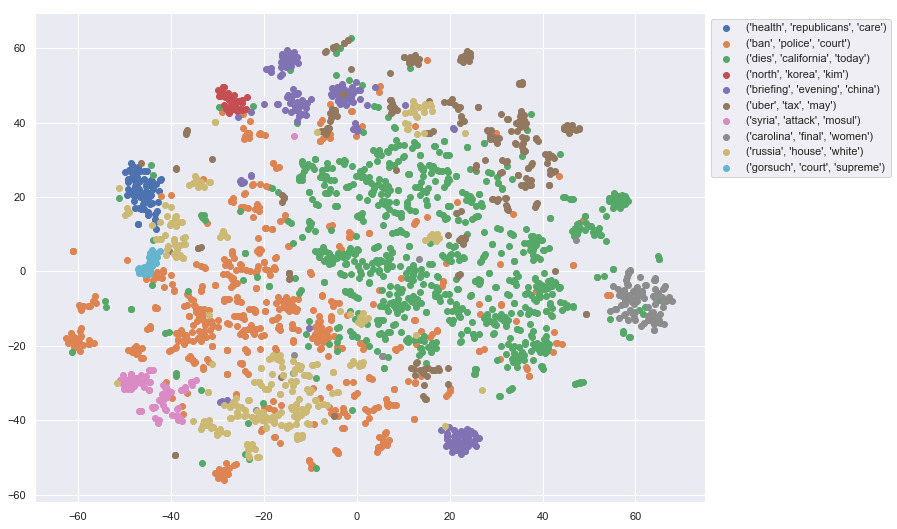

In [29]:
plt.figure(figsize=(12,9))
predictData['X'] = X_embedded[:,0]
predictData['Y'] = X_embedded[:,1]
for i in predictData.ag_label.unique():
    plt_data = predictData[predictData.ag_label == i]
    plt.scatter(plt_data.X, plt_data.Y, label=i)
    
plt.legend(bbox_to_anchor=(1.0, 1.0))

## Analysis

As we can see, now there is less overlap in the clusters. This is because of the hierarchical way in which clusters are merged and the fact that we have slightly less clusters. As we would expect NYT articles to have significant overlap given the nature of their national audience, a more robust clustering algorithm such as this should be considered for further analysis. 

# Future analysis

The above workbook shows two ways in which clustering can be used to group data. If given more time, I would approach the following: 

1. Design a clusering algorithm that included more relavant features. 
    One example is that the area the article was written, I.E. "Washington --" is encoded at the beginning of the document. Additionally, the authorship is currently excluded from clustering. If a distance measure could be computed for these features, these would lead to more robust cluster. 
2. Explore different stemmers and their effects on the data
3. Spend time determining a better way to label the clusters
4. Explore different word encodings such as word2vec, bag of words, and others to see if a better feature space could be designed for these documents.